In [13]:
import os, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import shutil, glob, math

DATA_ROOT = Path("../data/raw/DFL Bundesliga Data Shootout")
TRAIN_DIR = DATA_ROOT/"train"
TEST_DIR = DATA_ROOT/"test"
SAMPLE_DIR = Path("../data/raw/bundesliga_sample")
OUT_FRAMES = Path("../data/interim/bundesliga_frames")

SAMPLE_DIR.mkdir(parents=True, exist_ok=True)
OUT_FRAMES.mkdir(parents=True, exist_ok=True)

In [2]:
def index_videos(root: Path, split: str):
    rows = []
    for mp4 in root.rglob("*.mp4"):
        folder = mp4.parent.name
        rows.append({
            "split": split,
            "folder": folder,
            "filename": mp4.name,
            "rel_path": str(mp4.relative_to(DATA_ROOT)),
            "abs_path": str(mp4.resolve())
        })
    return rows

rows = []
rows += index_videos(TRAIN_DIR, "train")
rows += index_videos(TEST_DIR,  "test")
df_idx = pd.DataFrame(rows).sort_values(["split","folder","filename"]).reset_index(drop=True)
df_idx, df_idx.shape

(     split       folder              filename  \
 0     test         test          test (1).mp4   
 1     test         test         test (10).mp4   
 2     test         test         test (11).mp4   
 3     test         test         test (12).mp4   
 4     test         test         test (13).mp4   
 ..     ...          ...                   ...   
 455  train  E3c993bd2_0  E3c993bd2_0 (79).mp4   
 456  train  E3c993bd2_0   E3c993bd2_0 (8).mp4   
 457  train  E3c993bd2_0  E3c993bd2_0 (80).mp4   
 458  train  E3c993bd2_0  E3c993bd2_0 (81).mp4   
 459  train  E3c993bd2_0   E3c993bd2_0 (9).mp4   
 
                                    rel_path  \
 0                         test/test (1).mp4   
 1                        test/test (10).mp4   
 2                        test/test (11).mp4   
 3                        test/test (12).mp4   
 4                        test/test (13).mp4   
 ..                                      ...   
 455  train/E3c993bd2_0/E3c993bd2_0 (79).mp4   
 456   train/E

In [3]:
def probe(video_path: str):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
    n   = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) or 0)
    h   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) or 0)
    cap.release()
    return {"fps": fps, "frames": n, "duration_sec": (n/fps if fps>0 else None), "resolution": f"{w}x{h}"}

sample_probe = (df_idx
                .groupby(["split","folder"], group_keys=False)
                .apply(lambda g: g.sample(1, random_state=0))
                .reset_index(drop=True)
                .head(10))

probe_rows = []
for _, r in sample_probe.iterrows():
    probe_rows.append({**r, **probe(r.abs_path)})
pd.DataFrame(probe_rows)

/tmp/ipykernel_1805854/727196770.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_probe = (df_idx


,split,folder,filename,rel_path,abs_path,fps,frames,duration_sec,resolution
0,test,test,test (4).mp4,test/test (4).mp4,/mnt/iusers01/fse-ugpgt01/compsci01/w92120kd/t...,25.0,750,30.00,1920x1080
1,train,A1606b0e6_0,A1606b0e6_0 (57).mp4,train/A1606b0e6_0/A1606b0e6_0 (57).mp4,/mnt/iusers01/fse-ugpgt01/compsci01/w92120kd/t...,25.0,749,29.96,1920x1080
2,train,B1606b0e6_1,B1606b0e6_1 (11).mp4,train/B1606b0e6_1/B1606b0e6_1 (11).mp4,/mnt/iusers01/fse-ugpgt01/compsci01/w92120kd/t...,25.0,750,30.00,1920x1080
3,train,C35bd9041_0,C35bd9041_0 (37).mp4,train/C35bd9041_0/C35bd9041_0 (37).mp4,/mnt/iusers01/fse-ugpgt01/compsci01/w92120kd/t...,25.0,750,30.00,1920x1080
4,train,D35bd9041_1,D35bd9041_1 (11).mp4,train/D35bd9041_1/D35bd9041_1 (11).mp4,/mnt/iusers01/fse-ugpgt01/compsci01/w92120kd/t...,25.0,750,30.00,1920x1080
5,train,E3c993bd2_0,E3c993bd2_0 (3).mp4,train/E3c993bd2_0/E3c993bd2_0 (3).mp4,/mnt/iusers01/fse-ugpgt01/compsci01/w92120kd/t...,25.0,750,30.00,1920x1080


In [6]:
def make_sample(df, k_per_folder=1, max_folders=4):
    out_train = SAMPLE_DIR/"train"; out_test = SAMPLE_DIR/"test"
    out_train.mkdir(parents=True, exist_ok=True); out_test.mkdir(parents=True, exist_ok=True)

    picked = []
    for split, sub in df.groupby("split"):
        folders = sub.folder.unique()[:max_folders]
        sub2 = sub[sub.folder.isin(folders)].groupby("folder", group_keys=False).apply(
            lambda g: g.sample(min(k_per_folder, len(g)), random_state=0)
        )
        for _, r in sub2.iterrows():
            src = Path(r.abs_path)
            dst_dir = (out_train if split=="train" else out_test)/r.folder
            dst_dir.mkdir(parents=True, exist_ok=True)
            shutil.copy2(src, dst_dir/src.name)
            picked.append(str((dst_dir/src.name).resolve()))
    return picked

picked_paths = make_sample(df_idx, k_per_folder=1, max_folders=4)
len(picked_paths), picked_paths[:3]

/tmp/ipykernel_1805854/3479322082.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub2 = sub[sub.folder.isin(folders)].groupby("folder", group_keys=False).apply(
/tmp/ipykernel_1805854/3479322082.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub2 = sub[sub.folder.isin(folders)].groupby("folder", group_keys=False).apply(


(5,
 ['/mnt/iusers01/fse-ugpgt01/compsci01/w92120kd/third-year-project/football-tracking/data/raw/bundesliga_sample/test/test/test (4).mp4',
  '/mnt/iusers01/fse-ugpgt01/compsci01/w92120kd/third-year-project/football-tracking/data/raw/bundesliga_sample/train/A1606b0e6_0/A1606b0e6_0 (57).mp4',
  '/mnt/iusers01/fse-ugpgt01/compsci01/w92120kd/third-year-project/football-tracking/data/raw/bundesliga_sample/train/B1606b0e6_1/B1606b0e6_1 (11).mp4'])

In [7]:
def extract_every(video_path: str, every=60, out_dir: Path=OUT_FRAMES):
    out_dir.mkdir(parents=True, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    i = 0; saved = 0
    base = Path(video_path).stem
    while True:
        ret, frame = cap.read()
        if not ret: break
        if i % every == 0:
            cv2.imwrite(str(out_dir/f"{base}_{saved:04d}.jpg"), frame)
            saved += 1
        i += 1
    cap.release()
    return saved

total_saved = sum(extract_every(p, every=60) for p in picked_paths)
total_saved

65

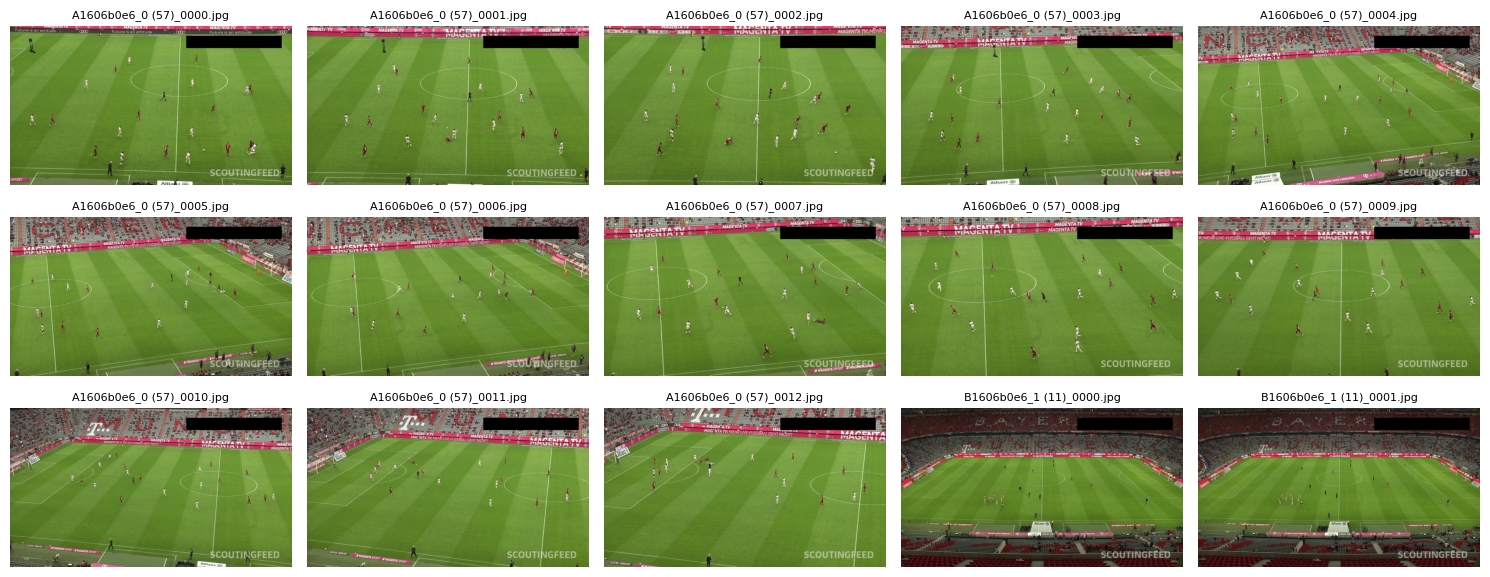

In [14]:
def show_grid(images, ncols=5, max_images=15, figsize=(15,6)):
    imgs = images[:max_images]
    nrows = math.ceil(len(imgs)/ncols)
    plt.figure(figsize=figsize)
    for i, path in enumerate(imgs):
        bgr = cv2.imread(path); 
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(nrows, ncols, i+1)
        ax.imshow(rgb); ax.axis("off"); ax.set_title(Path(path).name, fontsize=8)
    plt.tight_layout(); plt.show()

frames = sorted(glob.glob(str(OUT_FRAMES/"*.jpg")))
show_grid(frames, ncols=5, max_images=15)

vals=[]
for f in frames:
    img = cv2.imread(f); hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    vals.append(np.mean(hsv[:,:,2]))
vals = np.array(vals)